In [6]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse

In [2]:
torch.set_num_threads(30)

In [3]:
input_path = "../../appeal/snare_cellline/"
output_path = "../../appeal/snare_cellline/scMVP_output"

snare_cellline_dataset = {
                "gene_names": 'snare_cellline_scale_gene.txt',
                "gene_expression": 'snare_cellline_rna_normalize_count.mtx',
                "gene_barcodes": 'snare_cellline_cell_barcode.txt',
                "atac_names": 'snare_cellline_peak.txt',
                "atac_expression": 'snare_cellline_atac_normalize_count.mtx',
                "atac_barcodes": 'snare_cellline_cell_barcode.txt'
                }
dataset = LoadData(dataset=snare_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2021-07-23 15:21:22,275] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-07-23 15:21:25,145] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-07-23 15:21:25,186] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-07-23 15:21:25,188] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-07-23 15:21:25,554] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-07-23 15:21:25,574] INFO - scMVP.dataset.dataset | Downsampled from 1047 to 1047 cells


In [4]:
##### 
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0
n_centroids=8

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.exists("{}/multi_vae_trainer.pkl".format(output_path)):
    trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer.pkl".format(output_path)))
else:
    trainer.train(n_epochs=10, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)

trainer.model.eval()

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

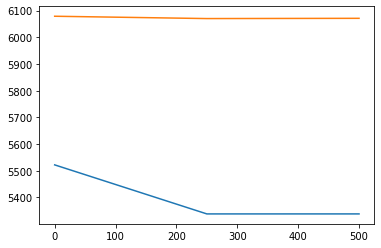

In [23]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

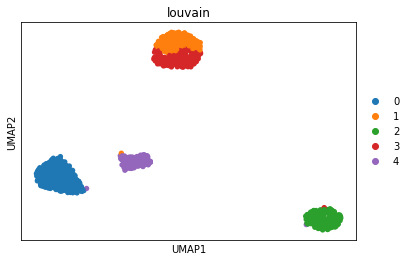

... storing 'kmeans' as categorical


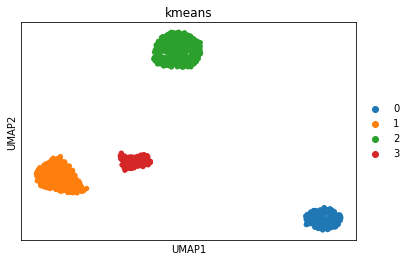

In [7]:

# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

# cluster by louvain
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# cluster by kmeans
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_umap"]

kmeans = KMeans(n_clusters=4, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])

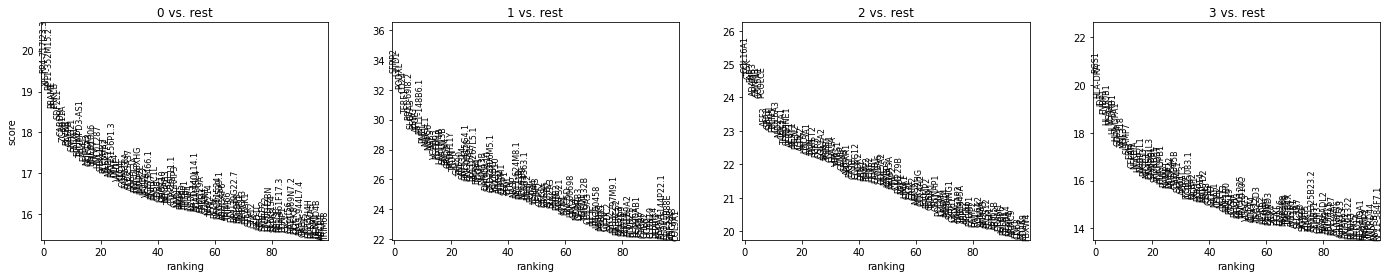

In [135]:
posterior_adata = anndata.AnnData(X=imputed_values[0])
posterior_adata.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] = prior_adata.obs['kmeans']
sc.tl.rank_genes_groups(posterior_adata, 'cell_type')
sc.pl.rank_genes_groups(posterior_adata, n_genes=100, sharey=False)
df_tmp=sc.get.rank_genes_groups_df(posterior_adata, group=str("0"))
df_tmp["group"] = str("0")
df_tab=df_tmp
for index in [str(i) for i in range(1,4)]:
    df_tmp=sc.get.rank_genes_groups_df(posterior_adata, group=index)
    df_tmp["group"] = str(index)
    df_tab = pd.concat([df_tab,df_tmp],axis=0)
df_tab.to_csv("{}/snare_cellline_DEG.csv".format(output_path),index=False)


In [ ]:

# save file
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=dataset.barcodes)
df.insert(0,"kmeans",prior_adata.obs['kmeans'].values)
df.to_csv(os.path.join(output_path,"multivae_umap.csv"))

df = pd.DataFrame(data=imputed_values[1].T, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation.csv"))

def binarization(imputed, raw):
    return (imputed.T > np.quantile(imputed,q=0.95,axis=1)).astype(np.int8)

atac_binary=binarization(imputed_values[1],dataset.atac_expression)
df = pd.DataFrame(data=atac_binary, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_no_pretrain_binary.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=dataset.barcodes, index=dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation.csv"))

In [8]:
def binarization(imputed, raw):
    return (imputed.T > np.quantile(imputed,q=0.95,axis=1)).astype(np.int8)

atac_binary=binarization(imputed_values[1],dataset.atac_expression)
df = pd.DataFrame(data=atac_binary, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_no_pretrain_binary.csv"))

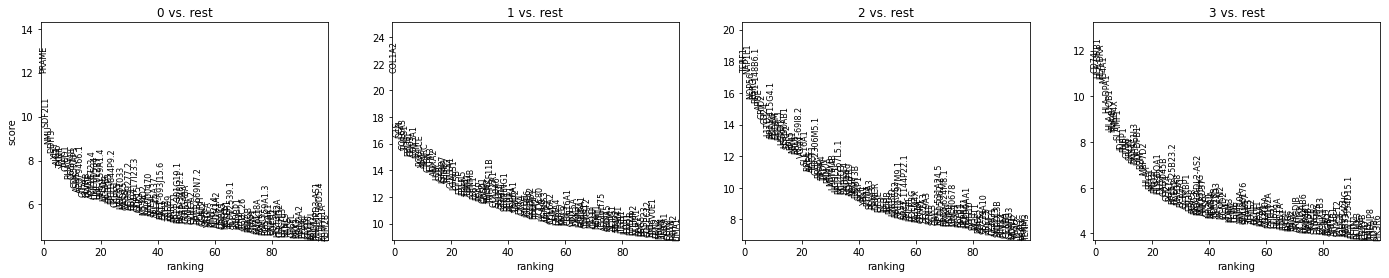

In [25]:
# compute raw data DEG

raw_data = anndata.AnnData(X=dataset.X)
raw_data.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
raw_data.obsm["X_multi_vi"] = latent
raw_data.obs['cell_type'] = prior_adata.obs['kmeans']
sc.tl.rank_genes_groups(raw_data, 'cell_type')
sc.pl.rank_genes_groups(raw_data, n_genes=100, sharey=False)
df_tmp=sc.get.rank_genes_groups_df(raw_data, group=str("0"))
df_tmp["group"] = str("0")
df_tab=df_tmp
for index in [str(i) for i in range(1,4)]:
    df_tmp=sc.get.rank_genes_groups_df(raw_data, group=index)
    df_tmp["group"] = str(index)
    df_tab = pd.concat([df_tab,df_tmp],axis=0)
df_tab.to_csv("{}/snare_cellline_raw_DEG.csv".format(output_path),index=False)
